In [683]:
import numpy as np
from tqdm import tqdm
from utils.plot_utils import *
import matplotlib.pyplot as plt
from astropy import units, constants

In [1]:
def multipass_prism_order(passes):
    npass = [1]
    for p in range(1,passes):
        if p%2 == 0:
            npass.append(p+1)
        else:
            npass.append(passes-p)
    return npass

In [80]:
nr_passes = 15
multipass_length = (1.75*units.imperial.inch).to(units.m)
beam_spacing = multipass_length/nr_passes
beam_locs = np.array([i*beam_spacing.value for i in range(nr_passes)])
beam_locs -= (beam_locs.max() - beam_locs.min() ) / 2
order = np.array(multipass_prism_order(nr_passes))-1

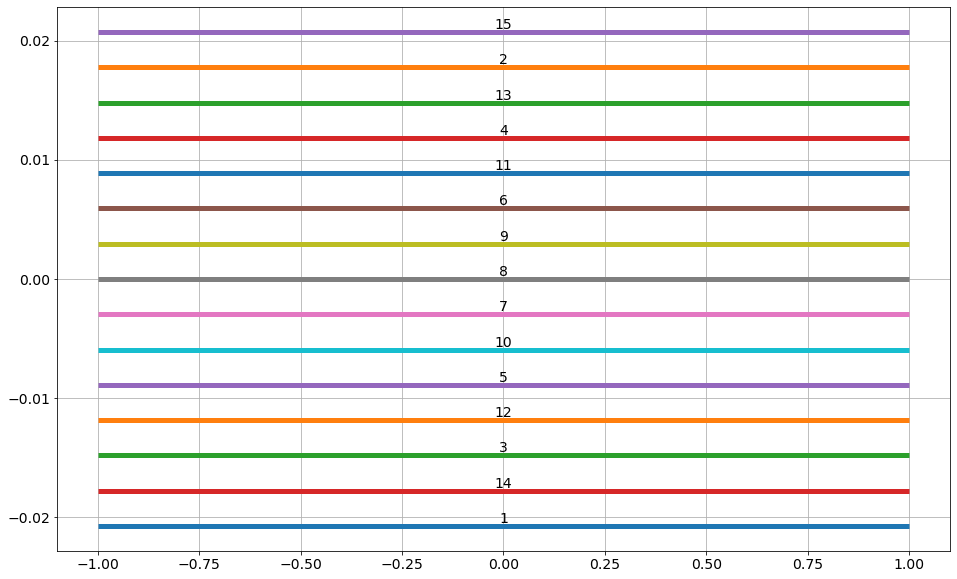

In [81]:
import matplotlib.colors as mcolors

fig, ax = plt.subplots(figsize = (16,10))

for idx, ido in enumerate(order):
    ax.text(0, beam_locs[ido], f"{idx+1}", ha = 'center', va = 'bottom', fontsize = 14)
ax.hlines(beam_locs[order], -1, 1, lw = 5, color = mcolors.TABLEAU_COLORS)

ax.grid(True)
set_fontsize(ax, 14)

## Prism reflection calculation

In [146]:
def perp( a ) :
    b = np.empty_like(a)
    b[0] = -a[1]
    b[1] = a[0]
    return b

def seg_intersect(a1,a2, b1,b2) :
    da = a2-a1
    db = b2-b1
    dp = a1-b1
    dap = perp(da)
    denom = np.dot( dap, db)
    num = np.dot( dap, dp )
    return (num / denom.astype(float))*db + b1

In [153]:
def line_intersection(line1, line2):
    xdiff = (line1[0][0] - line1[1][0], line2[0][0] - line2[1][0])
    ydiff = (line1[0][1] - line1[1][1], line2[0][1] - line2[1][1])

    def det(a, b):
        return a[0] * b[1] - a[1] * b[0]

    div = det(xdiff, ydiff)
    if div == 0:
       return np.nan

    d = (det(*line1), det(*line2))
    x = det(d, xdiff) / div
    y = det(d, ydiff) / div
    return x, y

In [296]:
class PrismPos:
    def __init__(self, x0, y0, w):
        self.x0 = x0
        self.y0 = y0
        self.w = w
    
    def a(self, x):
        return -(x-self.x0) + self.y0
    
    def aline(self):
        return np.array([self.x0, self.y0]), np.array([self.x0 - self.w/2, self.y0 + self.w/2])
    
    def b(self, x):
        return (x-(self.x0 - self.w/2)) + self.y0 + self.w/2
    
    def bline(self):
        return np.array([self.x0 - self.w/2, self.y0 + self.w/2]), np.array([self.x0, self.y0 + self.w])
    
    def check_abounds(self, x, y):
        line = self.aline()
        xline = [line[0][0], line[1][0]]
        yline = [line[0][1], line[1][1]]
        if (x >= min(xline)) & (x <= max(xline)) & (y >= min(yline)) & (y <= max(yline)):
            return True
        else:
            return False

    def check_bbounds(self, x, y):
        line = self.bline()
        xline = [line[0][0], line[1][0]]
        yline = [line[0][1], line[1][1]]
        if (x >= min(xline)) & (x <= max(xline)) & (y >= min(yline)) & (y <= max(yline)):
            return True
        else:
            return False

(array([0.2, 0.5]), array([-0.3,  1. ]))
(array([-0.3,  1. ]), array([0.2, 1.5]))


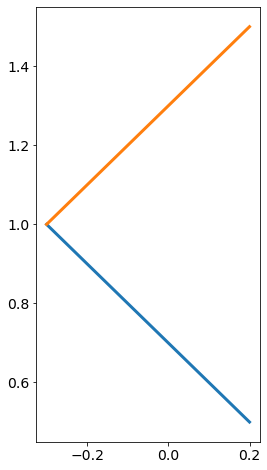

In [301]:
prism = PrismPos(0.2,0.5,1)

fig, ax = plt.subplots(figsize = (4,8))
x = np.linspace(0.2,-0.3,51)
ax.plot(x, prism.a(x), lw = 3)
ax.plot(x, prism.b(x), lw = 3)

set_fontsize(ax, 14)

print(prism.aline())
print(prism.bline())

In [377]:
class PrismNeg:
    def __init__(self, x0, y0, w):
        self.x0 = x0
        self.y0 = y0
        self.w = w
    
    def a(self, x):
        return (x-self.x0) + self.y0
    
    def aline(self):
        return np.array([self.x0, self.y0]), np.array([self.x0 + self.w/2, self.y0 + self.w/2])
    
    def b(self, x):
        return -(x-(self.x0 + self.w/2)) + self.y0 + self.w/2
    
    def bline(self):
        return np.array([self.x0 + self.w/2, self.y0 + self.w/2]), np.array([self.x0, self.y0 + self.w])
    
    def check_abounds(self, x, y):
        line = self.aline()
        xline = [line[0][0], line[1][0]]
        yline = [line[0][1], line[1][1]]
        if (x >= min(xline)) & (x <= max(xline)) & (y >= min(yline)) & (y <= max(yline)):
            return True
        else:
            return False

    def check_bbounds(self, x, y):
        line = self.bline()
        xline = [line[0][0], line[1][0]]
        yline = [line[0][1], line[1][1]]
        if (x >= min(xline)) & (x <= max(xline)) & (y >= min(yline)) & (y <= max(yline)):
            return True
        else:
            return False

(array([0.5, 3. ]), array([1. , 3.5]))
(array([1. , 3.5]), array([0.5, 4. ]))


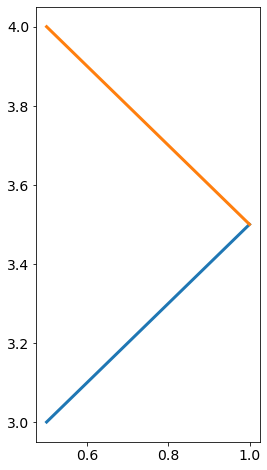

In [378]:
prism = PrismNeg(0.5,3,1)

fig, ax = plt.subplots(figsize = (4,8))
x = np.linspace(0,0.5,51) + 0.5
ax.plot(x, prism.a(x), lw = 3)
ax.plot(x, prism.b(x), lw = 3)

set_fontsize(ax, 14)

print(prism.aline())
print(prism.bline())

In [379]:
ray0 = np.array([0.5, 0.2]), np.array([-0.6, 0.2])
dray0 = np.diff(ray0, axis = 0)
dray0 /= np.linalg.norm(dray0)

In [407]:
from scipy.spatial.transform import Rotation as R
rb = R.from_euler('z', -90, degrees = True)
rb = rb.as_matrix()[:2,:2]
ra = R.from_euler('z', 90, degrees = True)
ra = ra.as_matrix()[:2,:2]

In [381]:
def check_intersection(ray, x,y):
    xline = [ray[0][0], ray[1][0]]
    yline = [ray[0][1], ray[1][1]]
    if (x >= min(xline)) & (x <= max(xline)) & (y >= min(yline)) & (y <= max(yline)):
        return True
    else:
        return False

In [563]:
def get_intersections(prism_offset, ray_offset):
    prism1 = PrismPos(-1,0,np.sqrt(2))
    prism2 = PrismNeg(1,prism_offset,np.sqrt(2))

    ray_start = np.array([2, ray_offset])
    ray_curr = ray_start.copy()
    ray_dr = np.array([-1,0])
    ray_len = np.array([10,10])

    intersections = []

    for refl in range(100):
        ray = ray_curr+ray_dr/100, ray_curr + ray_dr * ray_len

        refl = False
        for prism in [prism1, prism2]:
            intersection = seg_intersect(*ray, *prism.aline()) 
            if prism.check_abounds(*intersection) & check_intersection(ray, *intersection):
                intersections.append(intersection)
                normal = prism.aline()[1] - prism.aline()[0]
                normal /= np.linalg.norm(normal)
                dn = rb@normal
                refl = True
                break
            else:
                intersection = seg_intersect(*ray, *prism.bline())
                if prism.check_bbounds(*intersection) & check_intersection(ray, *intersection):
                    intersections.append(intersection)
                    normal = prism.bline()[1] - prism.bline()[0]
                    normal /= np.linalg.norm(normal)
                    dn = rb@normal
                    refl = True
                    break
        if not refl:
            break

        di = -ray_dr
        ray_dr = 2*(dn@di)*dn - di
        ray_curr = intersection
    return intersections, ray_dr, ray_start, prism1, prism2

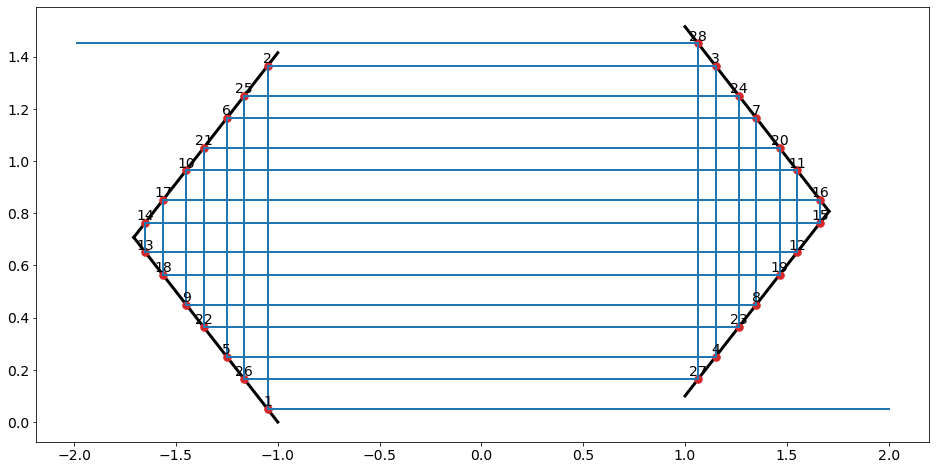

In [635]:
prism_offset = 0.1
ray_offset = 0.05

intersections, ray_dr, ray_start, prism1, prism2 = get_intersections(prism_offset, ray_offset)
fig, ax = plt.subplots(figsize = (16,8))

x = np.linspace(-1,-1-np.sqrt(2)/2,51)
ax.plot(x, prism1.a(x), lw = 3, color = 'k')
ax.plot(x, prism1.b(x), lw = 3, color = 'k')

x = np.linspace(1,1+np.sqrt(2)/2,51)
ax.plot(x, prism2.a(x), lw = 3, color = 'k')
ax.plot(x, prism2.b(x), lw = 3, color = 'k')

for idp, pos in enumerate(intersections):
    ax.plot(*pos, '.', ms = 15, color = 'C3')
    ax.text(*pos, f"{idp+1}", va = 'bottom', ha = 'center', fontsize = 14)

    
ray_curr = ray_start.copy()
for pos in intersections:
    x = ray_curr[0], pos[0]
    y = ray_curr[1], pos[1]
    ax.plot(x, y, '-', color = 'C0', lw = 2)
    ray_curr = pos

dist = np.abs(ray_start - intersections[0])
x = [x[-1], x[-1] + ray_dr[0]*dist[0]]
y = [y[-1], y[-1] + ray_dr[1]*dist[1]]
ax.plot(x,y,'-', color = 'C0', lw = 2)
set_fontsize(ax, 14)

In [684]:
prism_offsets = np.linspace(0,1,501)
ray_offsets = np.linspace(0,1,501)

multipass_width = []
for prism_offset in tqdm(prism_offsets):
    for ray_offset in ray_offsets:
        if ray_offset >= prism_offset:
            continue
        intersections, ray_dr, ray_start, prism1, prism2 = get_intersections(prism_offset, ray_offset)
        if len(intersections) <= 1:
            continue
        multipass_width.append((ray_offset, prism_offset, 
                                (np.array(intersections).max(axis = 0)-np.array(intersections).min(axis = 0))[-1],
                               len(intersections)/2 + 1))
multipass_width = np.array(multipass_width)

100%|████████████████████████████████████████████████████████████████████████████████| 501/501 [01:21<00:00,  6.15it/s]


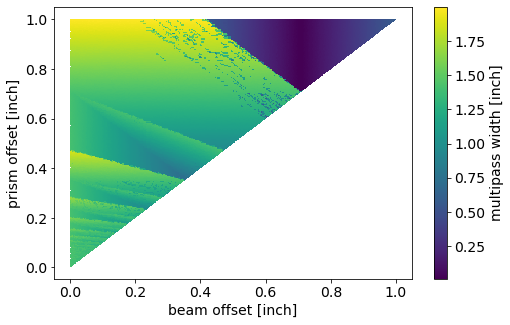

In [685]:
x = multipass_width[:,0]
y = multipass_width[:,1]
z = multipass_width[:,2]

fig, ax = plt.subplots(figsize = (8,5))
cs = ax.tripcolor(x,y,z)
cbar = fig.colorbar(cs)

ax.set_xlabel('beam offset [inch]')
ax.set_ylabel('prism offset [inch]')
cbar.ax.set_ylabel(r"multipass width [inch]")

set_fontsize(ax, 14)
set_fontsize(cbar.ax, 14)

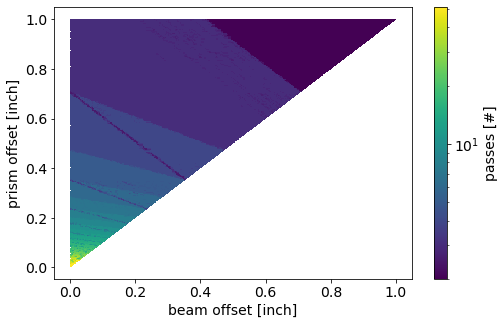

In [686]:
import matplotlib.colors as colors

x = multipass_width[:,0]
y = multipass_width[:,1]
z = multipass_width[:,3]

fig, ax = plt.subplots(figsize = (8,5))
cs = ax.tripcolor(x,y,z, norm = colors.LogNorm())
cbar = fig.colorbar(cs)

ax.set_xlabel('beam offset [inch]')
ax.set_ylabel('prism offset [inch]')
cbar.ax.set_ylabel(r"passes [#]")

set_fontsize(ax, 14)
set_fontsize(cbar.ax, 14)

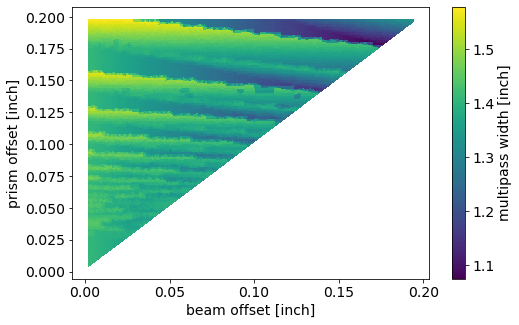

In [690]:
x = multipass_width[:,0]
y = multipass_width[:,1]
z = multipass_width[:,2]

m = (x < 0.2) & (y < 0.2)

fig, ax = plt.subplots(figsize = (8,5))
cs = ax.tripcolor(x[m],y[m],z[m])
cbar = fig.colorbar(cs)

ax.set_xlabel('beam offset [inch]')
ax.set_ylabel('prism offset [inch]')
cbar.ax.set_ylabel(r"multipass width [inch]")

set_fontsize(ax, 14)
set_fontsize(cbar.ax, 14)

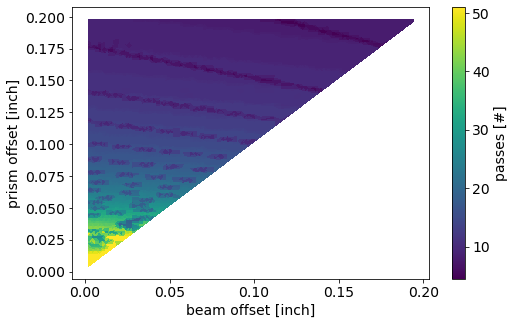

In [687]:
x = multipass_width[:,0]
y = multipass_width[:,1]
z = multipass_width[:,3]

m = (x < 0.2) & (y < 0.2)

fig, ax = plt.subplots(figsize = (8,5))
cs = ax.tripcolor(x[m],y[m],z[m])
cbar = fig.colorbar(cs)

ax.set_xlabel('beam offset [inch]')
ax.set_ylabel('prism offset [inch]')
cbar.ax.set_ylabel(r"passes [#]")

set_fontsize(ax, 14)
set_fontsize(cbar.ax, 14)